# Evaluierung und Interpretation

Sie haben in den Einheiten zur Datenmodellieren schon einige wichtige Punkte zum Thema "Evaluierung" gesehen: Die geeigneten Evaluationsmaße und ihre Interpretation, oder die methodisch saubere Trennung von Parameter- und Modellauswahl gegenüber den ungesehenen Testdaten, die die Generalisierbarkeit der Ergebnisse garantiert.

In diesem Abschnitt liegt der Fokus darauf, Ihre Ergebnisse einzuordnen und zu erklären (also auf Eigenschaften der Daten zurückzuführen). Dieser Schritt kommt beim reinen Machine Learning oft zu kurz, bringt aber die eigentlichen Einsichten.

Wir behandeln die folgenden Aspekte:

* Evaluierung: Wie gut ist das Modell im Vergleich?
    * zu einem anderen Modell: Baselines
    * zu sich selbst über die Zeit: Über- und Unteranpassung (overfitting/underfitting) mit Hilfe von Lernkurven prüfen 

* Interpretation: Welche Attribute sind (für welchen Teil der Daten) besonders wichtig? 

# Evaluierung

## 1. Baselines

Die Evaluationsergebnisse Ihres Modells sind für sich genommen schwer zu interpretieren: Ist ein F-Wert von 0.8 gut oder schlecht? Um dies besser einschätzen zu können, formulieren oder trainieren wir Vergleichsmodelle, sogenannte Baselines, bei denen wir davon ausgehen, dass unser Modell sie schlagen sollte (z.B. weil es mächtiger ist, also mehr Parameter besitzt, um die Eigenschaften der Daten abzubilden).

### 1.1 Frequenzbaseline (Klassifikation)
Eine sehr naive Baseline, die aber bei stark unausgewogenen Datensätzen dennoch hoch informativ ist, ist die Frequenzbaseline (bei Klassifikationsaufgaben). Sie wird berechnet, indem allen Datenpunkten die häufigste Klasse zugewiesen wird. Bei einem binären Klassifikationsproblem mit einer sehr häufigen Klasse kann die Frequenzbaseline bereits sehr hoch liegen - gegen eine Frequenzbaseline von F=0.9 sieht F=0.8 des trainierten Systems vielleicht gar nicht so eindrucksvoll aus. Im Vergleich der Konfusionsmatritzen mag das wieder anders aussehen; hier wird beim vermeintlich schlechteren System der kleineren Klasse sicher mehr korrekt zugewiesen als bei der Frequenzbaseline.

Wir verwenden in diesem Abschnitt unseren Ausschnitt aus den 20 Newsgroups-Daten als Beispiel. 

In [1]:
# Imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report

In [18]:
# 20 Newsgroups-Daten holen und in Train - Dev - Test aufteilen
categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

remove = ('headers', 'footers', 'quotes')

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)


In [3]:
# Übersicht über Klassen in den Trainingsdaten

print("Gesamtzahl Datenpunkte Training: ", len(y_train))

for i in range(0,4):
    print("Anzahl Kategorie", str(i), list(y_train).count(i))

Gesamtzahl Datenpunkte Training:  1627
Anzahl Kategorie 0 384
Anzahl Kategorie 1 467
Anzahl Kategorie 2 474
Anzahl Kategorie 3 302


Die häufigste Klasse ist also 2. 

In [4]:
# Und die Entwicklungsdaten?
print("Gesamtzahl Datenpunkte Dev: ", len(y_dev))
for i in range(0,4):
    print("Anzahl Kategorie", str(i), list(y_dev).count(i))

Gesamtzahl Datenpunkte Dev:  407
Anzahl Kategorie 0 96
Anzahl Kategorie 1 117
Anzahl Kategorie 2 119
Anzahl Kategorie 3 75


**Aufgabe**: Berechnen Sie mit Hilfe von sklearn.metrics.f1_score(average='weighted') das Ergebnis, wenn wir für die Testdaten immer '2' vorhersagen.

In [5]:
# Lösung: 

# Vorhersage-Array bauen: Für jedes Element der Entwicklungsdaten Klasse '2' vorhersagen
pred = np.full(len(y_dev),2)


**Aufgabe**: Das Ergebnis ist ziemlich niedrig - warum?

### 1.2 Mittelwertsbaseline (Regression)

Die entsprechende Baseline für eine Regressionsaufgabe ist, auf den Testdaten immer den Mittelwert der Trainingsdaten vorherzusagen. Auch hier hängt die Aussagekraft der Baseline von den Daten ab: Variieren die Zielwerte sehr stark, ist die Mittelwertvorhersage natürlich ähnlich schlecht wie die Frequenzbaseline im Beispiel für die Klassifikation.

Es folgt ein Beispiel mit den California-Housing-Daten (s. Kap. "Regression", Aufgabe).


In [6]:
# Imports
from sklearn.datasets import fetch_california_housing
import sklearn.ensemble
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

In [7]:
# Daten laden
data = fetch_california_housing(as_frame=True)

# Daten aufteilen
b_X_train, b_X_test, b_y_train, b_y_test = train_test_split(data.data, data.target, test_size=.2)


In [8]:
# Modell trainieren

clf = LinearRegression()
clf.fit(b_X_train, b_y_train)

# Modell evaluieren

test_predict = clf.predict(b_X_test)
print("RMSE der Modellvorhersagen: ", sqrt(mean_squared_error(b_y_test, test_predict)))

# Mittelwertsvorhersage: Vorhersage ist ein Array in Länge der Testdaten, der an jeder Position den
# Mittelwert der Zieldaten aus dem Trainingsset enthält

test_predict_mean = np.full(len(b_y_test),b_y_train.mean())

print("RMSE der Mittelwertsbaseline: ", sqrt(mean_squared_error(b_y_test, test_predict_mean)))



RMSE der Modellvorhersagen:  0.7232561838693107
RMSE der Mittelwertsbaseline:  1.1628367462545748


Wir sehen auch hier, dass das trainierte Modell deutlich besser ist als die naive Baseline.


### 1.3 Einfaches Vergleichsmodell

Wir können auch ein bewusst einfaches Modell zum Vergleich trainieren (z.B. den Naive Bayes-Lerner für die Klassifikation oder ein einfaches lineares Modell für die Regression). Das haben wir beim Kapitel über Regression bereits getan: Unser bewusst simples Modell mit nur einem (theoretisch motivierten) Feature stellte eine Art untere Grenze für die weiteren Modellierungsschritte dar. 

Hier ein Beispiel mit einem einfachen Naive Bayes-Klassifikator für unsere 20 Newsgroups-Daten.


In [19]:
# Aus Kap. "Klassifikation" die besten Settings für die Pipeline abschreiben; 
# Der Lerner soll Naive Bayes sein; dieser Lerner akzeptiert keine spärlich besetzten Vektoren, 
# daher ein zusätzlicher Transformationsschritt

baseline_pipeline = Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.5)),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'), threshold='mean')),
                ('densify_vectors',FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), 
                ('classifier', GaussianNB())])

baseline_pipeline.fit(data_train['data'], data_train['target'])

# Lerner auf den Testdaten evaluieren

dev_labels = baseline_pipeline.predict(data_test['data'])

print(classification_report(data_test['target'], dev_labels))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       319
           1       0.68      0.89      0.77       389
           2       0.82      0.66      0.73       394
           3       0.54      0.61      0.57       251

    accuracy                           0.68      1353
   macro avg       0.68      0.67      0.66      1353
weighted avg       0.69      0.68      0.68      1353



Gemessen an dieser Baseline sind unsere Ergebnisse mit dem SVM (per crossvalidation auf den Trainingsdaten erhoben) ganz gut: weighted average F-Score war dort 0.79.

Der SVM schlägt also die (in diesem Fall ziemlich niedrige) Frequenzbaseline deutlich und ist auch besser als ein bewusst einfach gehaltenes Modell: Im Vergleich mit anderen Modellen schneidet er gut ab. 

Dennoch sind Precision und Recall noch nicht (sehr) nahe an 1. Sehen wir also Underfitting, und das das Modell könnte noch besser werden? Im nächsten Schritt (Abschnitt 2) betrachten wir, wie er sich im Lernprozess verhält, vergleichen das Modell also quasi gegen sich selber.

## 2. Over-/Underfitting mit Lernkurven prüfen

Wenn wir ein Modell trainiert haben, möchten wir sicher sein, dass es 1. bestmöglich funktioniert und 2. generalisiert, also auf ungesehenen Daten vergleichbare Performanz zeigt.

Der erste Wurf beim Training eines Modells ist meistens noch suboptimal: Das Modell hat nicht alle generalisierbaren Eigenschaften der Daten gelernt (dies nennt sich underfitting). Je länger Sie auf den Trainings- und Entwicklungsdaten arbeiten, desto besser wird Ihr Modell - zunächst bildet es die generalisierbaren Eigenschaften der Daten besser ab, aber ab einem bestimmten Punkt lernt es, die nicht-generalisierbaren Details abzubilden (overfitting) und wird dadurch auf ungesehenen Daten schlechter.

Sie suchen also den Punkt, an dem das Modell genau "die richtigen" Eigenschaften der Daten gelernt hat. Dafür dürfen Sie aber nicht die ungesehenen Testdaten zu Hilfe nehmen, denn sonst riskieren Sie die implizite Überanpassung an die Testdaten, die dann nicht mehr ungesehen sind und die Generalisierbarkeit der Ergebnisse nicht mehr garantieren können.

Wir sind also auf Trainings- und Entwicklungsdaten angewiesen und behelfen uns damit, anzuschauen, wie das Modell auf diesen beiden Datensätzen funktioniert. Natürlich wird die Performanz auf den Trainingsdaten "zu gut" sein - diese sind ja bekannt... Aber so haben wir zwei Datensätze, auf denen wir evaluieren können, ohne die Testdaten anzuschauen.

Als zweiten Trick schauen wir uns an, wie das Modell auf mehr und mehr Trainingsdaten reagiert. Wir teilen dafür die Trainingsdaten in kleine Abschnitte und plotten die Modellperformanz mit zunehmender Trainingsdatenmenge. Anfangs wird die Lernkurve des Modells für beide Datensätze relativ steil ansteigen, weil es mehr und mehr verwertbare Information aus immer größeren Tranchen der Entwicklungsdaten ziehen kann; irgendwann flacht die Kurve aber möglicherweise ab, falls die übrigen Trainingsdaten keine neue Information mehr liefern. 

Liegen die Maximalwerte nah beieinander und der Maximalwert ist auch noch relativ niedrig (im Vergleich zu den Baselines), liegt wahrscheinlich **Underfitting** vor: Das Modell ist nicht mächtig genug, um die weiteren Trainingsdaten effizient zu nutzen. 

Ein Modell, das auf den Trainingsdaten wenig Fehler macht, aber auf den Entwicklungsdaten konsistent deutlich schlechter abschneidet, zeigt eher **Overfitting**; es ist offenbar mächtig genug, um über die relevanten Dateneigenschaften hinaus noch weitere Details zu lernen und würde von mehr Trainingsdaten profitieren.

Wir probieren die Lernkurvenanalyse für den SVM-Klassifizierer aus.

In [20]:
# Lernkurve erstellen (Code angepasst von Géron (2019), Kap. 4):

# Jeweils in Schritten von 100 Trainingsbeispielen iterieren; 
# bei jedem Durchlauf trainieren und auf Trainings- und Entwicklungsdaten 
# testen

# Achtung hierbei: Trainingsdaten müssen randomisiert sein, damit
# nicht zunächst nur eine Klasse im Training präsentiert wird.
# (Unsere Daten in den nächsten Schritten sind randomisiert!)

# Ergebnisse (F-Scores) plotten.


def plot_learning_curves(model, X_train,y_train, X_dev, y_dev):
    train_fs, dev_fs = [], []
    for m in range(100, X_train.shape[0],100):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_dev_predict = model.predict(X_dev)
        train_fs.append(f1_score(y_train[:m], y_train_predict,average='weighted'))
        dev_fs.append(f1_score(y_dev, y_dev_predict, average='weighted'))
    plt.plot(train_fs, "r-+", linewidth=2, label="train")
    plt.plot(dev_fs, "b-", linewidth=3, label="dev")
    plt.legend()
    plt.xlabel('Index der Trainingsiteration')
    plt.ylabel('F-Score des Lerners')

Wir bereiten aus Effizienzgründen die Daten auf, bevor wir die Lernkurve plotten. Die ursprünglichen Textdaten werden wie im Kap. "Klassifikation" vektorisiert, die Dimensionen dabei per TF-IDF ausgewählt. Anschließend werden die aussagekräftigsten Dimensionen ausgewählt.

**Aufgabe:** Gibt es auch Argumente dafür, die Datenaufbereitung bei jedem Schritt (also für jeden neu erstellten Teildatensatz) neu durchzuführen?

In [33]:
# Trainings- und Entwicklungsdaten vorbereiten: Aus Texten Vektoren erstellen und die besten Features auswählen

X_train, X_dev, y_train, y_dev = train_test_split(data_train['data'], data_train['target'], 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=data_train['target'])

vectorizer = TfidfVectorizer(max_df=0.5)
data_train_vectorized = vectorizer.fit_transform(X_train)

featureSelector = SelectFromModel(estimator=LinearSVC(dual=False,penalty='l1'))
data_train_optimal = featureSelector.fit_transform(data_train_vectorized, y_train)

data_dev_vectorized = vectorizer.transform(X_dev)
data_dev_optimal = featureSelector.transform(data_dev_vectorized)


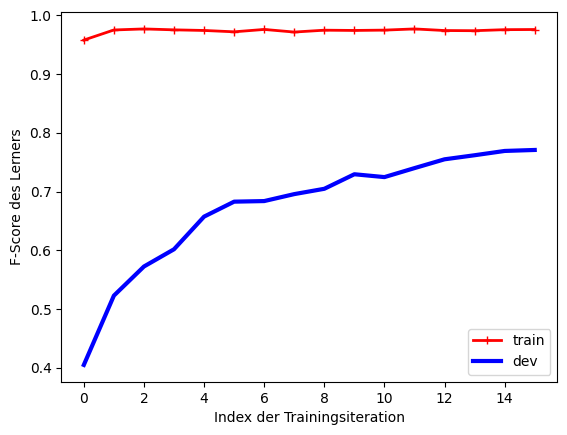

In [35]:
# Lerner vorbereiten: SVM
svm = SVC() 

# Lernkurve plotten - läuft eine Weile!

plot_learning_curves(svm, data_train_optimal, y_train, data_dev_optimal, y_dev)


**Aufgabe**: Was ziehen Sie aus diesem Plot für Schlüsse? Haben wir eher Over- oder Underfitting? Wie könnten wir gegensteuern?

# Interpretation

Wir haben bislang gesehen, wie wir die Performanz eines Lerners absolut (gegen Baselines) und relativ (in Bezug auf sein eigenes Lernverhalten) einschätzen können. Damit bekommen wir einen guten Eindruck vom Verbesserungspotential des gewählten Ansatzes auf den zur Verfügung stehenden Daten.

Vom Standpunkt der Datenanalyse her interessiert uns aber auch, welche Eigenschaften der Daten (also welche Features) besonders relevant für den Lerner sind. Dies haben wir bei der linearen Regression explizit evaluiert, und entsprechend können Sie auch die gelernten Modelle von transparenten Algorithmen wie Entscheidungsbäumen direkt interpretieren. 

Aber auch für Algorithmen, deren Modelle nicht menschenlesbar sind, gibt es Verfahren, die das Lernerverhalten erklären sollen. Diese können auch für transparente Algorithmen zusätzlich eingesetzt werden!

Ein Ansatz, den wir aus Aufwandsgründen nicht selber ausprobieren werden, ist das sog. **Adversarial Testing** (also etwa "feindseliges Testen"). Hier überlegt man sich im Voraus Testfälle, für die man das Verhalten des Lerners genauer prüfen möchte. Das können Fälle aus der Grauzone zwischen zwei Kategorien sein, oder zu erwartende fehlerhafte Eingaben durch Endnutzer. Dann wird das trainierte Modell auf (größeren Mengen) solcher Testdaten evaluiert. Dadurch hat man gezielt Einblick in relevante Teilbereiche der Daten, die im Testdatensatz ggf. unterrepräsentiert sind.

Wir werden stattdessen einen anderen Ansatz ausprobieren: [LIME](https://github.com/marcotcr/lime) ("Local Interpretable Model-agnostic Explanations", [Paper](https://arxiv.org/pdf/1602.04938.pdf)). Dieser hat das Ziel, für jede Testinstanz individuell zu begründen, warum der trainierte Lerner seine Vorhersage gemacht hat. Dies ist natürlich hoch relevant, wenn Sie den Endnutzer:innen die Möglichkeit geben möchten, Modellvorhersagen selbst zu interpretieren. 

Ein Beispiel: Hautärzt:innen verwenden oft automatisierte Systeme, um Muttermale mit Hautkrebspotential zu entdecken. Eine Systemausgabe, die die Bewertung als "riskant" oder "nicht riskant" begründet, ermöglicht den Ärzt:innen, ihre eigene Einschätzung und die des Systems zu gewichten und vielleicht doch zu einer abweichenden Interpretation zu gelangen, statt blind dem System zu folgen. 

Ebenso ist in der DSGVO geregelt, dass Verbraucher:innen ein Recht darauf haben, dass ihnen Entscheidungen aufgrund eines Algorithmus erläutert werden; dann braucht man exakt solche Einzelfallbegründungen, wie LIME sie liefern kann.

LIME funktioniert folgendermaßen: Der Algorithmus geht davon aus, dass der zu testende Lerner eine Black Box ist. Wir kennen also nur seine Ausgabe als Reaktion auf die Eingabefeatures. Um zu verstehen, welche Eingabefeatures die Ausgabe besonders beeinflusst haben, trainieren wir jetzt einen transparenten Lerner darauf, **die Ausgabe des Black Box-Lerners** vorherzusagen. Der transparente Lerner wird uns dann sagen, welche Features besonders wichtig waren, um die Black Box möglichst gut zu imitieren.

Leider bleibt das Problem, dass der transparente Lerner (ein lineares Modell) ggf. nicht mächtig genug ist, um die Black Box korrekt zu emulieren (sonst hätte man ja wahrscheinlich gar nicht erst einen intransparenten Algorithmus gewählt...). Jetzt kommt der Namensbestandteil "Local" ins Spiel: Der Algorithmus bricht das Problem auf das Umfeld des aktuellen Testdatenpunkts herunter. Er ignoriert also große Teile der Trainingsdaten, die im Moment gar nicht relevant sind. Stattdessen simuliert er Instanzen, die sich in der Nähe des Testdatenpunkts befinden und lernt aus ihnen ein lokales Entscheidungsmodell, das dem Verhalten der Black Box an dieser Stelle entspricht. Für die Textklassifikation werden z.B. zufällig Wörter aus dem Text weggelassen, um die ähnlichen Dokumente zu generieren. 

Wir probieren es aus... Wir folgen dem LIME-Tutorial für den Multiclass-Fall (also mehr als zwei Zielklassen). LIME ist auch im binären Klassifikationsfall und für Regressionsprobleme anwendbar; Tutorials dazu gibt es ebenfalls im verlinkten GitHub-Projekt.

## Erklärungen für einzelne Instanzen

Wir probieren es aus... Wir folgen dem LIME-Tutorial für den Multiclass-Fall (also mehr als zwei Zielklassen). LIME ist auch im binären Klassifikationsfall und für Regressionsprobleme anwendbar; Tutorials dazu gibt es ebenfalls im verlinkten GitHub-Projekt.

In [28]:
# Imports
from __future__ import print_function

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


from lime import lime_text
from lime.lime_text import LimeTextExplainer



In [36]:
# Vorbereitung der Daten (sicherheitshalber noch einmal)

# Trainings- und Entwicklungsdaten aus 20 Newsgroups einlesen und aufteilen wie oben 

# 20 Newsgroups-Daten holen und in Train - Dev - Test aufteilen
categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

remove = ('headers', 'footers', 'quotes')

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)

X_train, X_dev, y_train, y_dev = train_test_split(data_train['data'], data_train['target'], 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=data_train['target'])


# Wir benennen die Klassen noch menschenlesbar:
class_names=['atheism','graphics','space','religion.misc']

In [30]:
# Pipeline für Datenvorverarbeitung und Training (wie in Kap. 2 "Klassifikation")
# Lerner: SVM wie oben, aber Ausgabe einer Wahrscheinlichkeitsverteilung über alle Klassen

c = Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.5)),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classifier', SVC(probability=True))])

# Pipeline trainieren
c.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.5)),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classifier', SVC(probability=True))])

In [37]:
# Der Lerner gibt eine Wahrscheinlichkeitsverteilung über die verschiedenen Klassen aus:

print(c.predict_proba([X_dev[0]]).round(3))

[[0.561 0.163 0.119 0.156]]


In [38]:
# Explainer generieren

explainer = LimeTextExplainer(class_names=class_names)

In [39]:
# Erklärung für einen bestimmten Datenpunkt generieren: Index 42 
# Es sollen für die beiden wahrscheinlichsten Klassen (top_labels=2) 
# die jeweils 6 wichtigsten Features generiert werden (num_features=6)

idx = 1

exp = explainer.explain_instance(X_dev[idx], c.predict_proba, num_features=6, top_labels=2)

print('Document id: %d' % idx)

print('Predicted class:', class_names[c.predict([X_dev[idx]])[0]])
print('True class: %s' % class_names[y_dev[idx]])

Document id: 1
Predicted class: graphics
True class: graphics


In [40]:
# Welche beiden Labels wurden vorgeschlagen?
top_labels= exp.available_labels()

# Ausgabe textuell

print ('Explanation for class %s' % class_names[top_labels[0]])
print ('\n'.join(map(str, exp.as_list(top_labels[0]))))
print ()
print ('Explanation for class %s' % class_names[top_labels[1]])
print ('\n'.join(map(str, exp.as_list(top_labels[1]))))

Explanation for class graphics
('with', 0.22280875357861563)
('big', -0.1807320666899509)
('polygons', 0.15856698928030064)
('inside', 0.1286241852179909)
('you', -0.09782679334188744)
('use', 0.09405172204829168)

Explanation for class space
('with', -0.22343255473315313)
('polygons', -0.18450244628432444)
('big', 0.17603735500434836)
('inside', -0.10625047043680522)
('kind', 0.09426451521057765)
('test', 0.08551257639431308)


Positive Evidenzwerte weisen darauf hin, dass das entsprechende Feature für die Klasseneinteilung wichtig war, negative Evidenzwerte sprechen gegen die Klasse. Je größer der absolute Evidenzwert, desto wichtiger das Feature.

**Aufgabe**: Welche Features sprechen für "graphics" und gleichzeitig gegen "space"? Sind alle Features sofort plausibel?

In [41]:
# Sie können sich die Ausgabe auch visualisieren lassen:

exp.show_in_notebook(text=False)



**Aufgabe**: Wir haben mit den wichtigsten sechs Features gearbeitet. Trotz TF-IDF-Vektorizer und nachfolgender Feature-Auswahl sind häufige Wörter wie "you" oder "my" in den wichtigen Features übriggeblieben. Sie sind also offensichtlich aussagekräftig, aber für Menschen nicht sehr hilfreich. Gleichzeitig werden die Evidenzwerte immer kleiner; die Features nehmen also an Wichtigkeit ab. Experimentieren Sie mit der Anzahl der zu zeigenden Features: Was scheint Ihnen optimal?

In [42]:
# Wenn Sie sehen wollen, wo im Input die wichtigen Wörter auftauchen:
# 'labels' gibt an, welche Klasse Sie interessiert. Wir wählen die vorhergesagte Klasse 'graphics'.
# Es könnte zur Fehlersuche aber auch eine nicht vorhergesagte Klasse sein. Sie muss allerdings 
# in exp.available_labels() sein.

exp.show_in_notebook(text=X_dev[idx], labels=(2,))



## Erklärungen für das ganze Modell

Um eine Erklärung für die Entscheidungen des ganzen Modells zu bekommen, sieht LIME vor, eine wählbare Anzahl von repräsentativen Instanzen und ihre Erklärungen anzusehen. Hierzu gibt es ein [Tutorial](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Submodular%20Pick%20examples.ipynb), wenn Sie den Ansatz verwenden möchten.

Alternativ können wir auch für einen interessanten Datensatz (z.B. die Entwicklungsdaten) Erklärungen für alle besten Label generieren und jeweils pro Zielklasse die so gefundenen relevanten Features sammeln. So erhalten wir einen Überblick, welche Features für welche Zielklasse positive Evidenz darstellen.

In [43]:
exps_atheism={}
exps_religion={}
exps_space={}
exps_graphics={}

list_of_maps=[exps_atheism, exps_graphics, exps_space, exps_religion]

# Achtung, läuft lange!

for idx in range(0,len(y_dev)):
    
    # Zu kurze Dokumente sorgen für Probleme
    if (len(X_dev[idx])<50):
        continue
    
    # Das beste Label für jede Instanz erklären
    exp = explainer.explain_instance(X_dev[idx], c.predict_proba, num_samples=5000, num_features=6, top_labels=1)
    
    # Die wichtigsten sechs Features für das top_label und ihre Evidenzen (wenn positiv) ablegen
    top_label = exp.available_labels()[0] 
    feature_list = exp.as_list(top_label)
    
    for rep,w in feature_list:
        # nur positive Evidenzen zählen
        if w<0:
            continue
        if rep in list_of_maps[top_label]:
            list_of_maps[top_label][rep] += w
        else: 
            list_of_maps[top_label][rep] = w
    

In [44]:
# Klasse "Space"
dict(sorted(exps_space.items(), key=lambda item: item[1], reverse=True))

{'space': 4.532047870117163,
 'was': 1.7952088419066035,
 'Space': 1.5087167228263463,
 'at': 1.4107474316017425,
 'orbit': 1.122953355919315,
 'they': 1.066846159134587,
 'NASA': 1.058761526306829,
 'like': 0.9739226082289416,
 'year': 0.8200175878963829,
 'SPACE': 0.7342959242243406,
 'launch': 0.7134721867289163,
 'nasa': 0.6643592837659194,
 'would': 0.6563739653146742,
 'DC': 0.6238978420821393,
 'Earth': 0.5785651473830744,
 'cost': 0.5712382040648266,
 'earth': 0.4734932102257467,
 'They': 0.43920723849228593,
 'money': 0.412215453086364,
 'satellite': 0.4112734649243115,
 'be': 0.40229797697325,
 'spacecraft': 0.38403398283733603,
 'sky': 0.3788112001779861,
 'Moon': 0.3760910223608904,
 'costs': 0.3589199595997973,
 '23': 0.3460880940531164,
 'idea': 0.3203928190662413,
 'going': 0.31662015443038904,
 'someone': 0.30476906753266275,
 'wk': 0.29520737559191457,
 'thought': 0.28729281304448034,
 're': 0.28086461399219187,
 'Tommy': 0.2695825988599925,
 'mine': 0.2681896773351448

In [45]:
# Klasse "Graphics"
dict(sorted(exps_graphics.items(), key=lambda item: item[1], reverse=True))

{'graphics': 3.5080986666057226,
 've': 1.7929969506106638,
 'file': 1.759001229017589,
 'with': 1.4342617762190055,
 'looking': 1.3095130848826109,
 'code': 1.0249099150091838,
 'files': 1.0078722017902537,
 '3D': 0.9991362427254903,
 'Thanks': 0.9388351534802534,
 'points': 0.9374372047664358,
 'image': 0.9267291710260633,
 'Hi': 0.9083972861941854,
 'anyone': 0.8750155543974407,
 'use': 0.8463642881415548,
 'program': 0.841034493474195,
 'line': 0.7630510138273303,
 'Graphics': 0.7591006202442101,
 '3DO': 0.7338436896721715,
 'Image': 0.6694446095995404,
 'package': 0.6620739485427526,
 '3d': 0.6565851583330631,
 'algorithm': 0.6473620780503233,
 'need': 0.6452677506391006,
 'sphere': 0.6405715206811039,
 'Video': 0.6137974177450181,
 'ftp': 0.5821488262487023,
 'using': 0.5755612043843596,
 'images': 0.5652907263862761,
 'POV': 0.5643538295024246,
 'computer': 0.5328052403188379,
 'info': 0.5234147761285182,
 'version': 0.49666457695600275,
 'any': 0.48584334770221016,
 '68070': 0.

In [46]:
# Klasse "Atheism"
dict(sorted(exps_atheism.items(), key=lambda item: item[1], reverse=True))

{'you': 7.179846414784028,
 'not': 2.375555397972572,
 'an': 1.6693385368978213,
 'religion': 1.5971825182332282,
 'what': 1.5293621564059299,
 'don': 1.379209390770918,
 'Bobby': 1.229498897871446,
 'people': 1.1831415242128627,
 'atheists': 1.047092683207029,
 'posting': 0.9909732518527573,
 'motto': 0.9373888989014265,
 'must': 0.9184968967458345,
 'Islamic': 0.9020239699636885,
 'if': 0.8264590005829944,
 'TEK': 0.730892015928969,
 'You': 0.6255910592038745,
 'depression': 0.6220713690627959,
 'sex': 0.5987006412881204,
 'makes': 0.5852353257620522,
 'religious': 0.5644774838677725,
 'ICO': 0.532936640813228,
 'Cheat': 0.5169651515046064,
 'atheist': 0.5035901479652856,
 'so': 0.5011700955744158,
 'bobbe': 0.4683817466531254,
 'simply': 0.4603495988764523,
 'risk': 0.4460406523021335,
 'Americans': 0.4231122382567475,
 'God': 0.4183334583190034,
 'wouldn': 0.4179410862462022,
 'say': 0.4136159820479897,
 'Islam': 0.41359165226629624,
 'cause': 0.3926501935688115,
 'Bronx': 0.380976

In [47]:
# Klasse "Religion"
dict(sorted(exps_religion.items(), key=lambda item: item[1], reverse=True))

{'Jesus': 2.4305219169984706,
 'Christian': 2.1991841445791693,
 'Christians': 1.9373307886676632,
 'objective': 1.8443609345167946,
 'he': 1.7711184142601408,
 'his': 1.313111148284902,
 'who': 1.0399586709031254,
 'as': 0.8770164811297377,
 'Tyre': 0.8509282580684596,
 'He': 0.8226832561779338,
 'Mr': 0.8036954178836889,
 'God': 0.7880113863794422,
 'Kent': 0.7782098244006295,
 'me': 0.6856611862392453,
 'my': 0.6465753109035555,
 'Koresh': 0.5609510034609835,
 'children': 0.493637204311162,
 'were': 0.47628592096290656,
 'Catholic': 0.4724997103816741,
 'man': 0.4627144264793609,
 'Christ': 0.4515516980109615,
 'context': 0.438927103737315,
 'with': 0.4187170442196305,
 'writes': 0.33958150174284973,
 'her': 0.3378993613600558,
 'values': 0.32690370058707174,
 'humans': 0.3184047219930612,
 'may': 0.31420700898558573,
 'see': 0.3042525868343142,
 'those': 0.29993406756300706,
 'bible': 0.28793075127879564,
 'My': 0.28750399045829494,
 'from': 0.2870282534995917,
 'blood': 0.28278775

**Aufgabe**: Schauen Sie sich die indikativsten Features für jede Klasse an. Neben den unterschiedlichen Charakteristika der Texte fällt an den Wörtern selber schnell eine Verbesserungsmöglichkeit auf. Was könnten wir tun, um redundante Features zu vermeiden?